In [1]:
import numpy as np
import scipy as ci 
import seaborn as sns
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import tables 
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model as lm
from sklearn.decomposition import PCA

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

/Users/yang/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# set up plotting background and fonts
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

# read data

In [117]:
# read in data
df = pd.read_csv('developer_survey_2017/survey_results_public.csv')
schema = pd.read_csv('developer_survey_2017/survey_results_schema.csv')

In [120]:
print(df.shape)
df.head()

(51392, 154)


,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


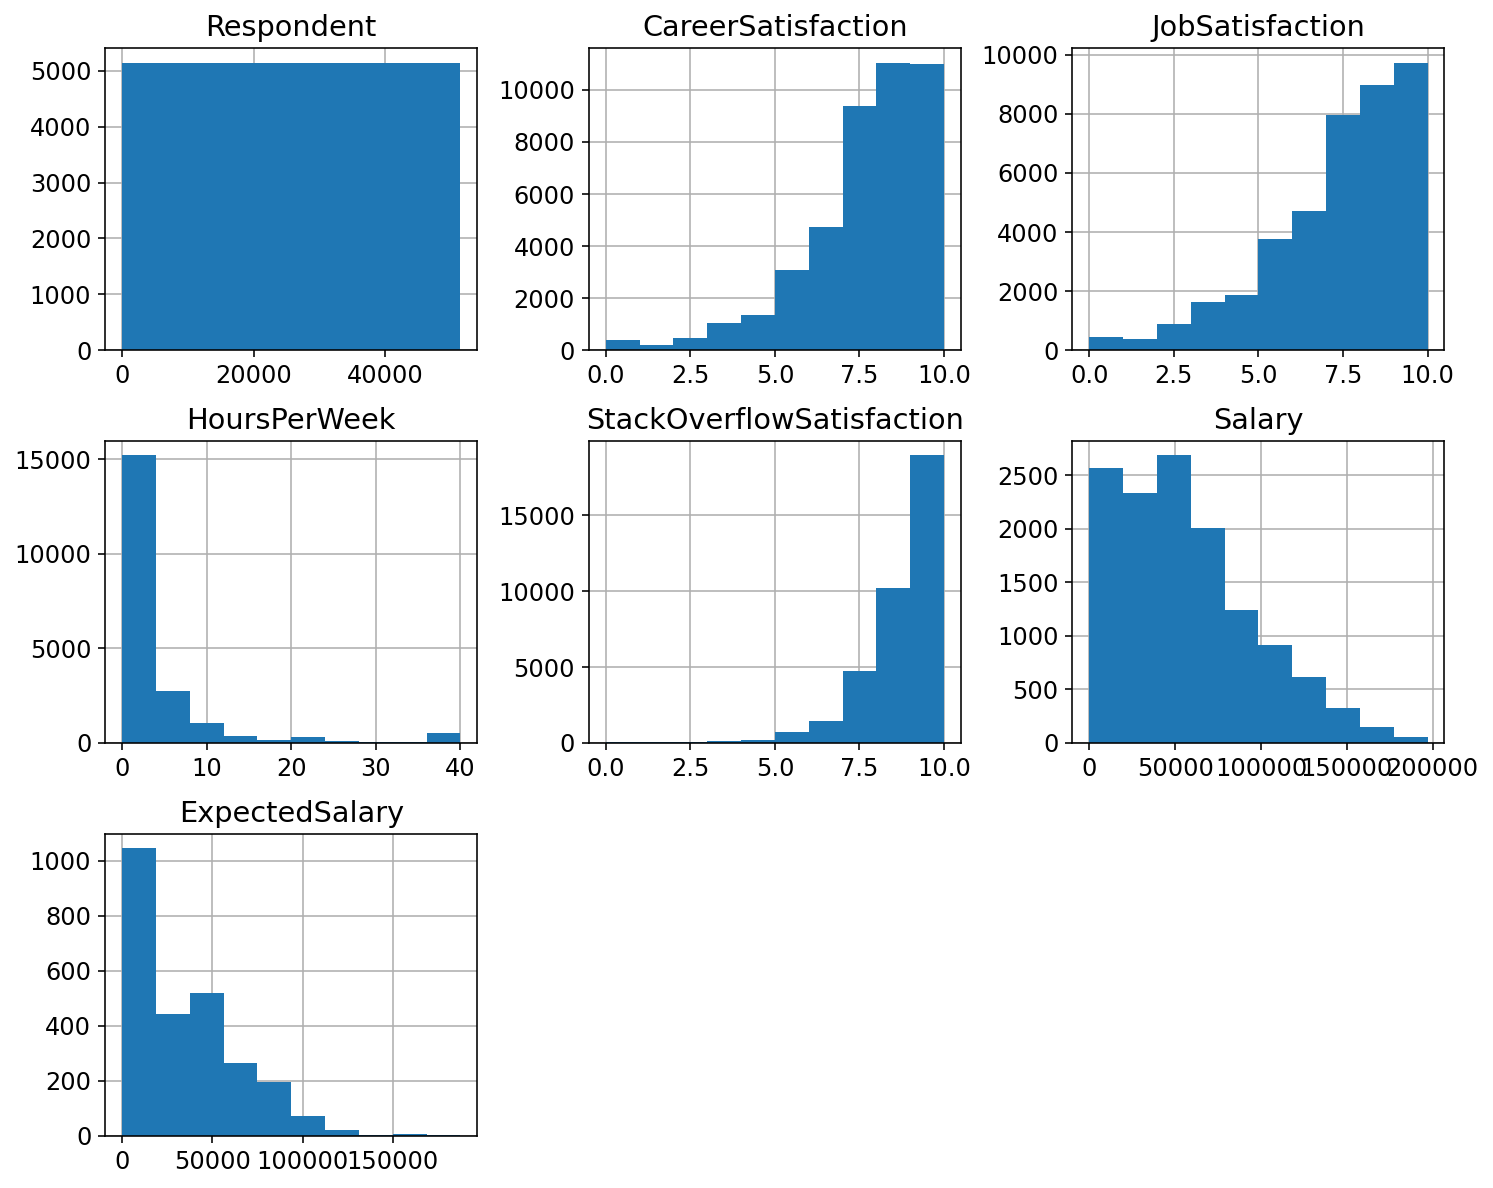

In [116]:
# visualizing numeric variables 
fig = plt.figure(figsize = (12,10))
ax = fig.gca()
df.hist(ax=ax)
plt.show()

# Q1: What are popular IDE, platforms, etc?

In [66]:
df = pd.read_csv('developer_survey_2017/survey_results_public.csv')
print(df.shape)

(51392, 154)


In [108]:
categorical_cols = df.select_dtypes(['object']).columns

def fraction(item, s):
    """
    Find the fraction of users for each tool. 
    
    Input: tool name, e.g. IDE, VersionControl; name for title
    Ouptut: name of the tool and the corresponding fraction of users
    """
    # what are possible unique answer occurrence?
    l = [] 
    tmp = df[item].loc[~df[item].isnull()] # all answers
    for i in tmp:
        l_tmp = i.split('; ')
        l += l_tmp
    answers = list(dict(Counter(l)).keys())
    
    name = []
    frac = []
    for answer in answers:
        def exist(x):
            if type(x)==str and answer in x:
                return 1
            return 0

        name.append(answer)
        frac.append(df[item].map(exist).mean())
    
    name, frac = np.array(name),np.array(frac)
    plt.figure(figsize=(10,4))
    p = sns.barplot(name[frac.argsort()[::-1]][:20], frac[frac.argsort()[::-1]][:20])
    plt.setp(p.get_xticklabels(),rotation=45,horizontalalignment='right',fontsize=10)
    plt.title('Most popular ' + s)
    plt.show()
    
    return np.array(name),np.array(frac)

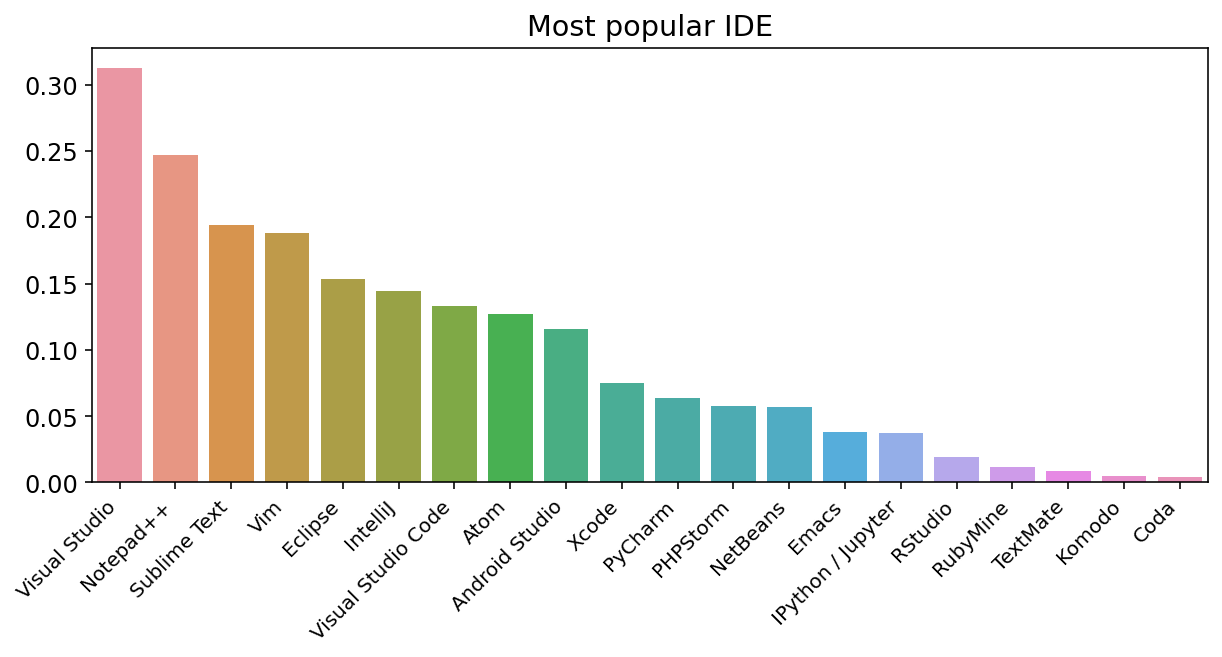

In [109]:
name,frac = fraction('IDE','IDE')

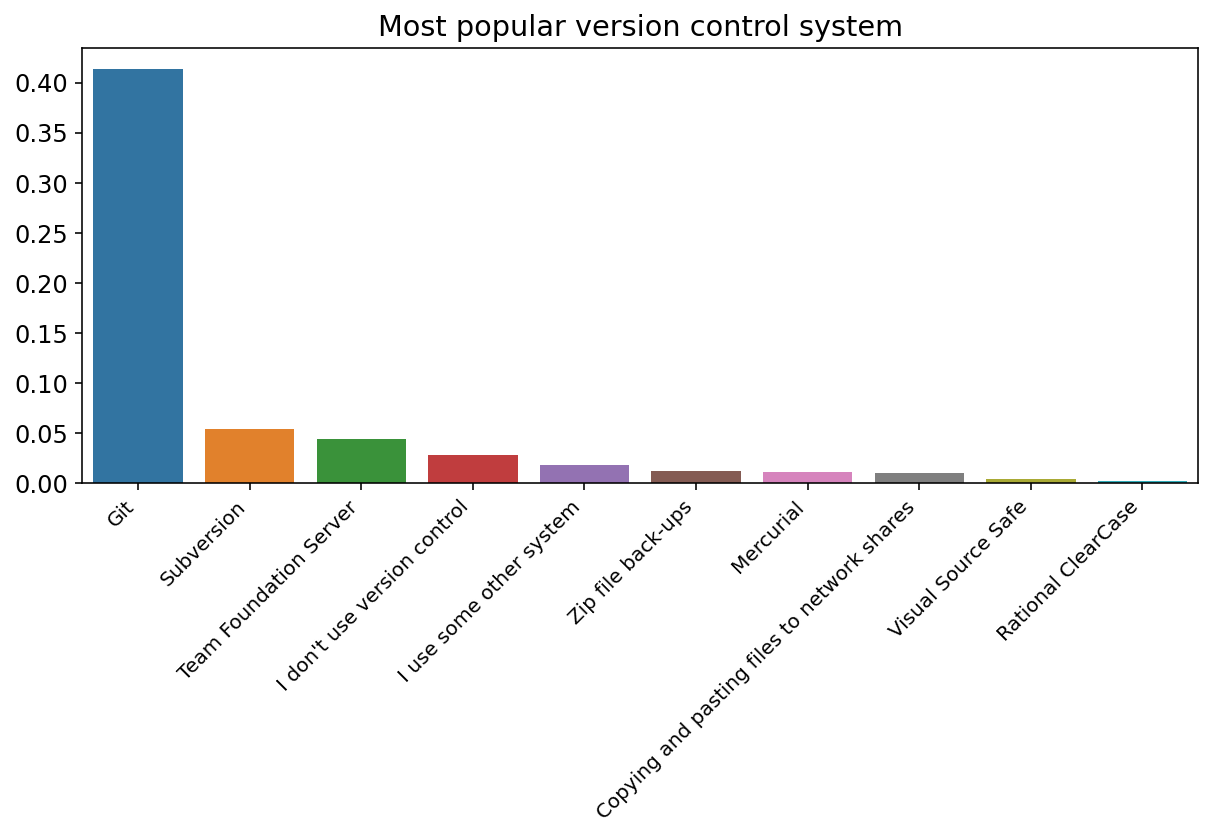

In [110]:
name,frac = fraction('VersionControl','version control system')

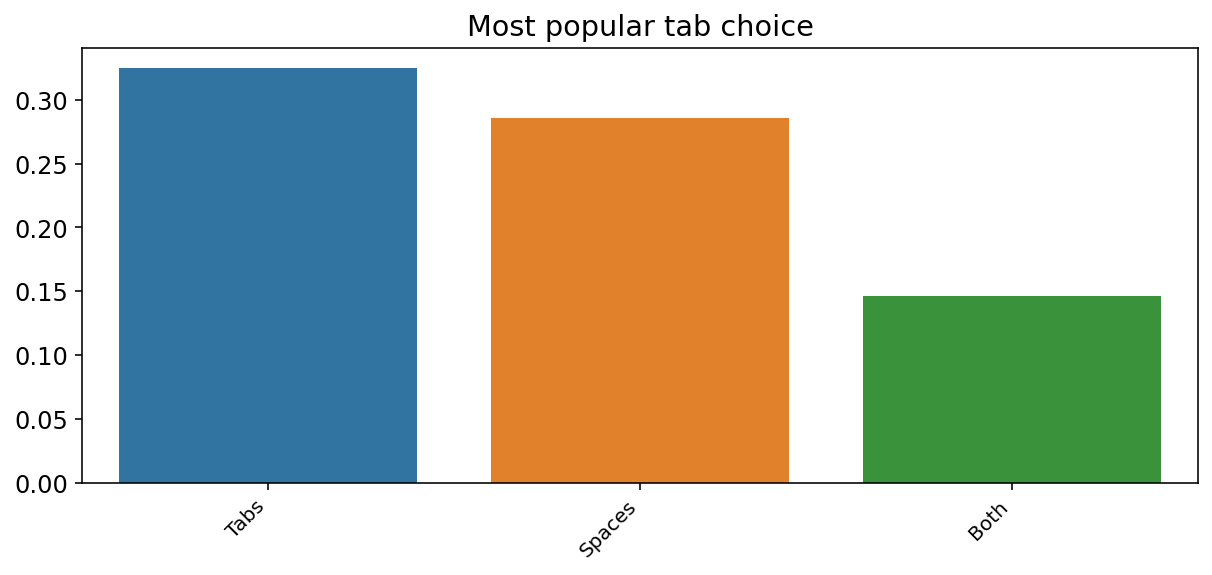

In [111]:
name,frac = fraction('TabsSpaces', 'tab choice')

# Q2: How do people value different aspects when applying for a job?

In [ ]:
df = pd.read_csv('developer_survey_2017/survey_results_public.csv')

In [123]:
# what are aspects to consider?
aspects = []
for name in list(df.columns):
    if 'AssessJob' in name:
        aspects.append(name)
print(aspects)

['AssessJobIndustry', 'AssessJobRole', 'AssessJobExp', 'AssessJobDept', 'AssessJobTech', 'AssessJobProjects', 'AssessJobCompensation', 'AssessJobOffice', 'AssessJobCommute', 'AssessJobRemote', 'AssessJobLeaders', 'AssessJobProfDevel', 'AssessJobDiversity', 'AssessJobProduct', 'AssessJobFinances']


In [124]:
# use some words to explain each aspect for future visualization
explain = {'AssessJobIndustry':'Industry to work in', 
 'AssessJobRole':'Job role or title', 
 'AssessJobExp':'Experience level required', 
 'AssessJobDept':'Department or team', 
 'AssessJobTech':'Language or framework', 
 'AssessJobProjects':'How projects managed', 
 'AssessJobCompensation':'Compensation and benefit', 
 'AssessJobOffice':'Office environment', 
 'AssessJobCommute':'Commuting time', 
 'AssessJobRemote':'Can work remotely', 
 'AssessJobLeaders':'Leader reputation', 
 'AssessJobProfDevel':'Development opportunity', 
 'AssessJobDiversity':'Diversity at company', 
 'AssessJobProduct':'Product impactful', 
 'AssessJobFinances':'Financial performance of company'}

In [125]:
# find the proportion of people thinking each aspect is important 
rating = ['Very important', 'Somewhat important', 'Important',
 'Not very important', 'Not at all important']
mapping = {'Very important':1, 'Somewhat important':1, 'Important':1,'Not very important':0, 'Not at all important':0 }

def find_aspect_ratios(df):
    """
    For each aspect of job, find the fraction of people that recognize it as important. 
    
    Input: original dataframe
    Output: a new dataframe with one column as aspect name, the other column as the fraction of people
    """
    dic = {}
    for aspect in aspects:
        tmp = df[aspect][~df[aspect].isnull()]
        dic[explain[aspect]] = np.mean(tmp.map(mapping))

    aspect_df = pd.DataFrame(list(dic.items()),columns=['aspect','proportion']).set_index(['aspect']).sort_values('proportion',ascending=False)     
    return aspect_df

In [126]:
# classify people with education level
def higher_ed(s):
    """
    Convert education level strings to numbers. Number 1 means higher education. 
    """
    if (s in ["Master's degree", "Professional degree", "Doctoral degree"]):
        return 1
    else:
        return 0
df['HigherEd'] = df["FormalEducation"].apply(higher_ed)

df_high_ed = df.loc[df['HigherEd'] == 1]
df_low_ed = df.loc[df['HigherEd'] == 0]

In [127]:
# classify people who want to change world
def change_world(s):
    """
    Convert 'change world' column from strings to numbers. 
    """
    if (s in ['Agree', 'Somewhat agree', 'Strongly agree']):
        return 1
    else:
        return 0
df['WantToChangeWorld'] = df["ChangeWorld"].apply(change_world)

df_high_change_world = df.loc[df['WantToChangeWorld'] == 1]
df_low_change_world = df.loc[df['WantToChangeWorld'] == 0]

In [128]:
# classify people who want to change world
def coding_experience(s):
    """
    Convert years in coding to low and high coding experience. 
    """
    if (s in [  
                '10 to 11 years', 
                '11 to 12 years',
                '12 to 13 years',
                '13 to 14 years',
                '14 to 15 years',
                '15 to 16 years',
                '16 to 17 years',
                '17 to 18 years',
                '18 to 19 years',
                '19 to 20 years',
                '20 or more years', 
             ]):
        return 1
    else:
        return 0
df['CodingExperience'] = df["YearsCodedJob"].apply(coding_experience)

df_high_coding_experience = df.loc[df['CodingExperience'] == 1]
df_low_coding_experience = df.loc[df['CodingExperience'] == 0]

In [131]:
def table_plot(df1, df2, name1, name2):
    """
    Visualize how people value each aspect when applying for a job, grouped by people 
    with different education levels. 
    
    Input: two dataframes and names. 
    Output: dataframe for visulization.
    """

    ratio_1_perc = find_aspect_ratios(df1)
    ratio_2_perc = find_aspect_ratios(df2)

    comp_df = pd.merge(ratio_1_perc, ratio_2_perc, left_index=True, right_index=True)
    comp_df.columns = [name1, name2]
    comp_df['Fractional difference'] = (comp_df[name1] - comp_df[name2])/(comp_df[name1])
    out = comp_df.style.bar(subset=['Fractional difference'], align='mid', color=['dodgerblue', 'darkorange'])

    return out

In [132]:
table_plot(df_high_ed,df_low_ed,"Master's degree or above", "Bachelor's degree or below")

,Master's degree or above,Bachelor's degree or below,Fractional difference
aspect,,,
Development opportunity,0.968151,0.965921,0.002303
Compensation and benefit,0.960733,0.956810,0.004083
Office environment,0.944786,0.950236,-0.005768
Language or framework,0.935400,0.938465,-0.003277
Commuting time,0.932371,0.926051,0.006778
How projects managed,0.925823,0.925243,0.000626
Experience level required,0.891760,0.879998,0.013190
Financial performance of company,0.862718,0.872842,-0.011735
Department or team,0.848866,0.853535,-0.005501


In [133]:
table_plot(df_high_coding_experience,df_low_coding_experience,'> 10 yr working experience', '< 10 yr working experience')

,> 10 yr working experience,< 10 yr working experience,Fractional difference
aspect,,,
Compensation and benefit,0.976495,0.952590,0.024480
Commuting time,0.956180,0.919638,0.038217
Development opportunity,0.943997,0.972842,-0.030557
Language or framework,0.943746,0.935971,0.008238
Office environment,0.941918,0.950775,-0.009403
How projects managed,0.924043,0.925772,-0.001871
Experience level required,0.901815,0.877776,0.026656
Financial performance of company,0.885885,0.865809,0.022662
Department or team,0.823627,0.860367,-0.044608


In [134]:
table_plot(df_high_change_world,df_low_change_world,'want to change world', 'not change world')

,want to change world,not change world,Fractional difference
aspect,,,
Development opportunity,0.974117,0.956435,0.018153
Compensation and benefit,0.959219,0.956000,0.003356
Office environment,0.955556,0.939962,0.016319
Language or framework,0.938469,0.936629,0.001961
How projects managed,0.936451,0.910926,0.027257
Commuting time,0.932133,0.921819,0.011065
Experience level required,0.886880,0.878013,0.009997
Financial performance of company,0.874810,0.864182,0.012149
Department or team,0.865322,0.835316,0.034676


# Q3: Can we predict whether people are satisfied with their jobs?

In [149]:
df = pd.read_csv('developer_survey_2017/survey_results_public.csv')

In [150]:
# drop rows with nan satisfaction (which is our goal of prediction)
df = df.dropna(subset=['JobSatisfaction'],axis=0)

def binary(x):
    """
    Convert JobSatisfaction from a scale of 1 to 10 into binary form. 
    A value of 1 indicates satisfied, and 0 indicates disatisfied. 
    """
    if x >= 7: # threshold chosen to ensure a balance between classes
        return 1
    return 0

df['JobSatisfactionBinary'] = df['JobSatisfaction'].map(binary)
df = df.drop(['JobSatisfaction'],axis=1)

In [151]:
# drop col with more than 90% nulls
df = df.drop(df.columns[df.isnull().mean() > 0.9],axis=1);

# drop irrelevant or "cheating" cols
df = df.drop(['Respondent', 'CareerSatisfaction', 'StackOverflowSatisfaction'], axis=1);

print(df.shape)

(40376, 139)


In [152]:
# fill numerical nan with mean of col
numerical_cols = df.select_dtypes(['int','float']).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())

In [156]:
from collections import Counter

# clean categorical variables. 
categorical_cols = df.select_dtypes(['object']).columns

def clean_categorical(df, item):
    """
    Clean one categorical variable with the following steps:
        1. find all unique occurance of answers. 
        2. create new columns for each answer and fill with 1 or 0. 
        3. create a new column indicating nan in the original column. 
        4. delete the original column. 
    
    Input: original dataframe and column name.
    Output: modified dataframe. 
    """
    
    # 1. find unique answers
    l = [] 
    tmp = df[item].loc[~df[item].isnull()] # all answers
    for i in tmp:
        l_tmp = i.split('; ')
        l += l_tmp
    answers = list(dict(Counter(l)).keys())
    
    # 2. create new columns
    for answer in answers:
        def exist(x):
            if type(x)==str and answer in x:
                return 1
            return 0
        df[item+'_'+answer] = df[item].map(exist)
    
    # 3. clean up nulls
    def map_null(x):
        if type(x) != str:
            return 1
        return 0
    df[item+'_isnull'] = df[item].map(map_null)
    
    # 4. delete the old column
    df = df.drop([item],axis=1)
    return df

# perform cleaning on all categorical variables
for item in categorical_cols: 
    df = clean_categorical(df, item)

In [157]:
# extract feature matrix and truth target predictions. 
X = df.drop(['JobSatisfactionBinary'], axis=1) # JobSatisfaction
y = df['JobSatisfactionBinary'] # JobSatisfaction
print(X.shape)

(40376, 1280)


In [158]:
# split data into training and validation sets. Perform standardization. 
from sklearn.preprocessing import StandardScaler
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
print(X_train.shape, X_val.shape)

/Users/yang/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/yang/miniconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(32300, 1280) (8076, 1280)


/Users/yang/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/yang/miniconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [159]:
# use logistic regression
lg = lm.LogisticRegression()
lg.fit(X_train,y_train)
y_pred_train = lg.predict(X_train)
y_pred_val = lg.predict(X_val)

/Users/yang/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [160]:
# print accuracy
print(lg.score(X_train,y_train))
print(lg.score(X_val,y_val))

0.7403095975232198
0.7067855373947499


In [161]:
# extract feature names and corresponding importance. 
features = np.array(list(X.columns))
importance = lg.coef_[0]

# sort by feature importance
rank_good = importance.argsort()[::-1]
rank_bad = importance.argsort()

In [162]:
print(features[rank_good])
print(importance[rank_good])

print(features[rank_bad])
print(importance[rank_bad])

['JobSeekingStatus_I am not interested in new job opportunities'
 'Country_Nigeria' 'WorkPayCare_isnull' ... 'EquipmentSatisfiedCPU_isnull'
 'Country_Niger' 'JobSeekingStatus_I am actively looking for a job']
[ 0.39977861  0.20633288  0.17111257 ... -0.19199488 -0.24197355
 -0.42142657]
['JobSeekingStatus_I am actively looking for a job' 'Country_Niger'
 'EquipmentSatisfiedCPU_isnull' ... 'WorkPayCare_isnull' 'Country_Nigeria'
 'JobSeekingStatus_I am not interested in new job opportunities']
[-0.42142657 -0.24197355 -0.19199488 ...  0.17111257  0.20633288
  0.39977861]


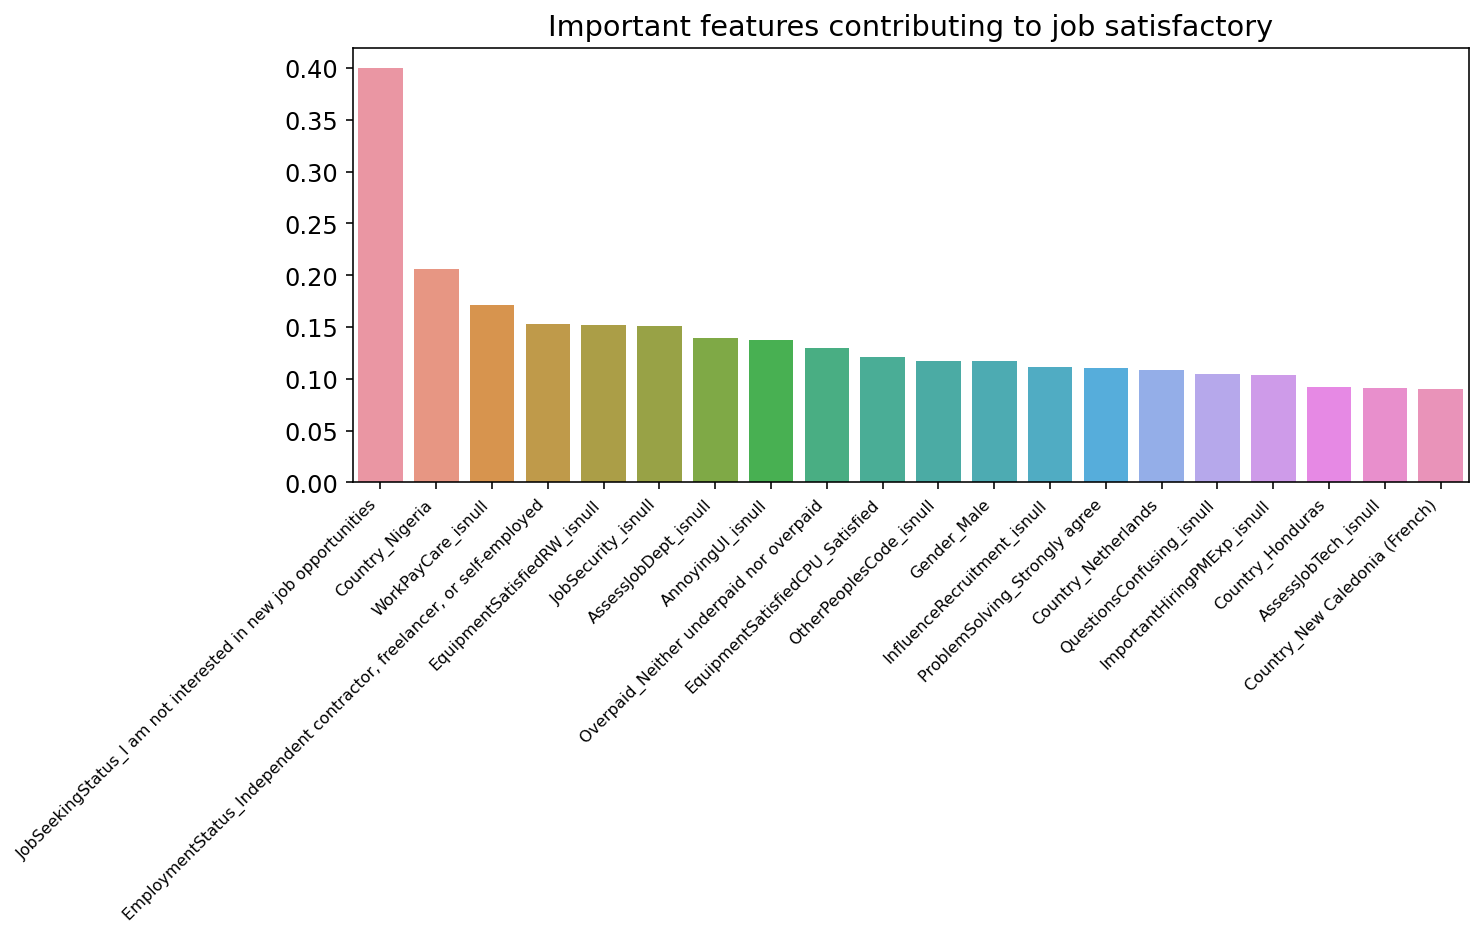

In [163]:
plt.figure(figsize=(10,4))
p = sns.barplot(features[rank_good][:20], importance[rank_good][:20],)
plt.setp(p.get_xticklabels(),rotation=45,horizontalalignment='right',fontsize=8)
plt.title('Important features contributing to job satisfactory')
plt.show()

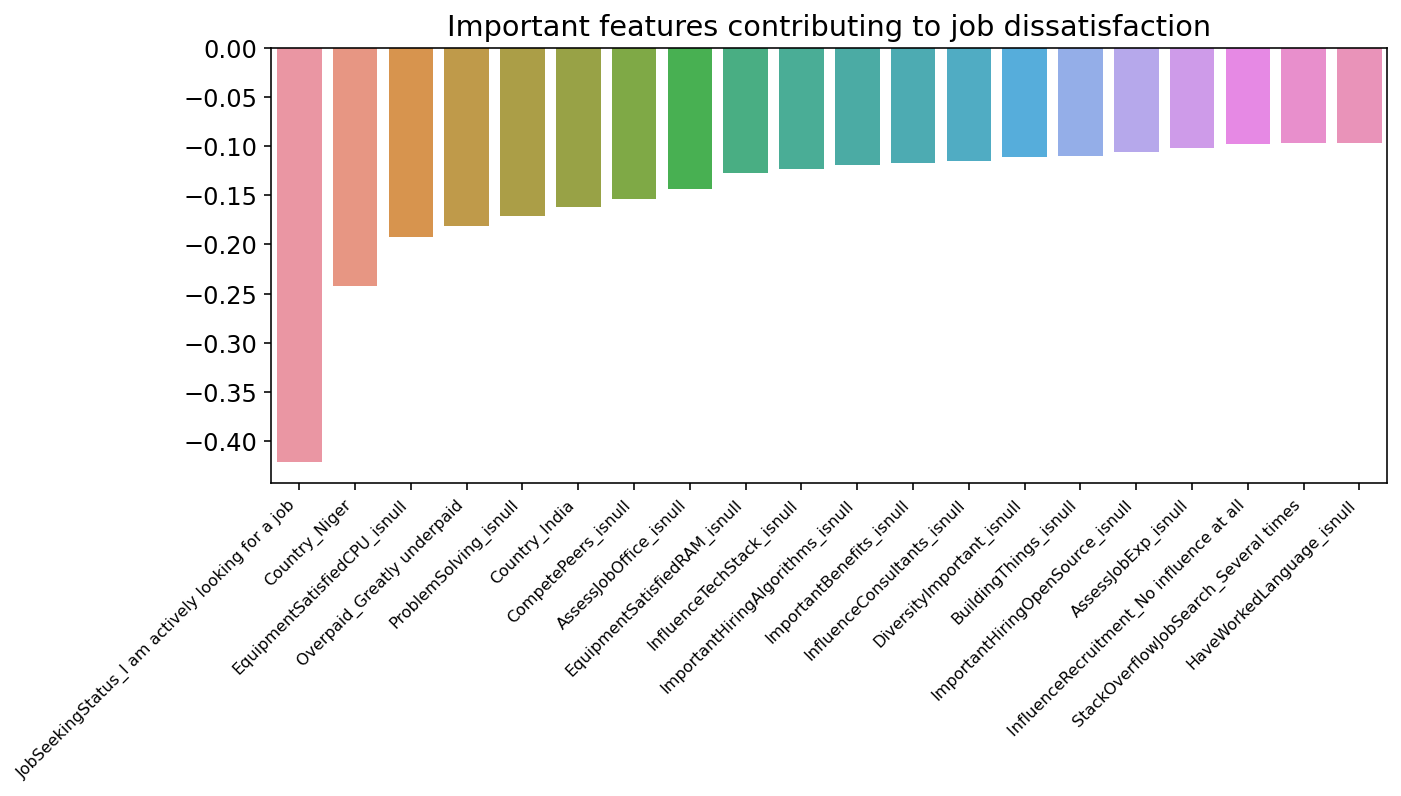

In [164]:
plt.figure(figsize=(10,4))
p = sns.barplot(features[rank_bad][:20], importance[rank_bad][:20])
plt.setp(p.get_xticklabels(),rotation=45,horizontalalignment='right',fontsize=8)
plt.title('Important features contributing to job dissatisfaction')
plt.show()